## Active Appearance Models (Intermediate results)

In [755]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.spatial import ConvexHull
import cv2
from sklearn.decomposition import PCA
from helper_functions import procrustes_align, AffineRegistrationLandmarks, generalized_procrustes_analysis, applyTransformation, rescale_to_original, inverse_warping

In [756]:
# Loading data
Working_directory=""
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']
N,M = Landmarks.shape # number subjects
H, W = Images.shape[1:]
dim = 2
M = int(M/dim) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M)
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


# Designing the covariate model for shape and texture

(136,)
Iter number 1 , Error: 0.000585


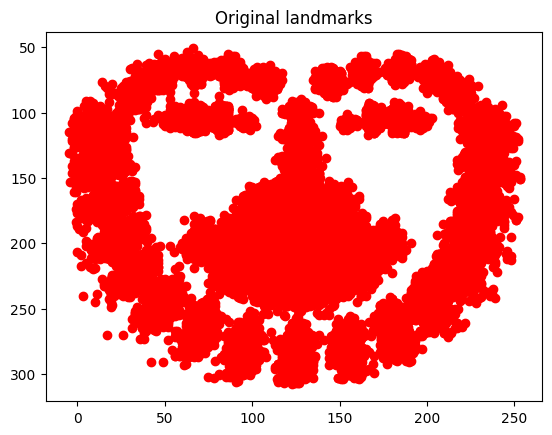

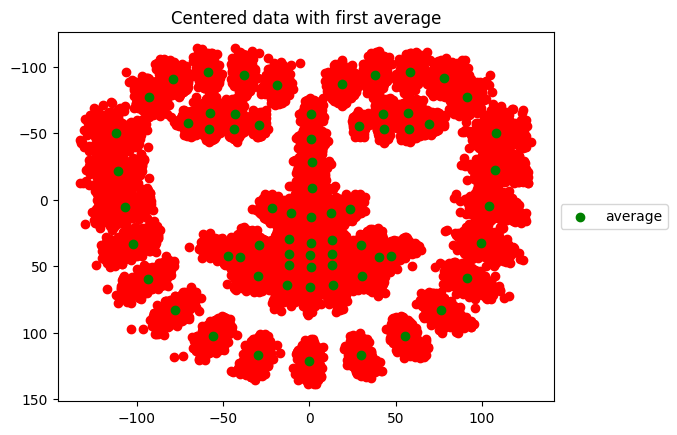

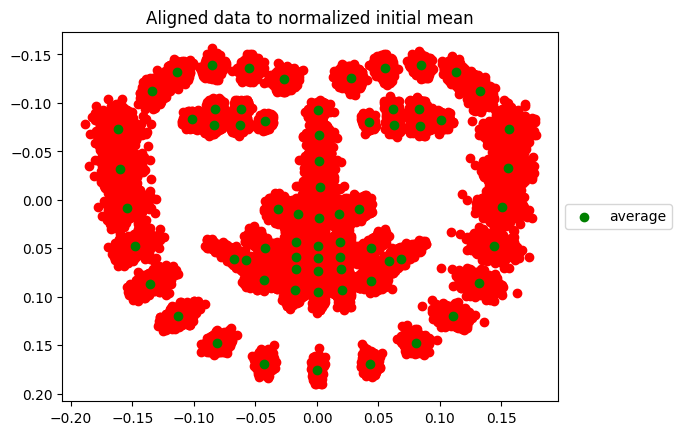

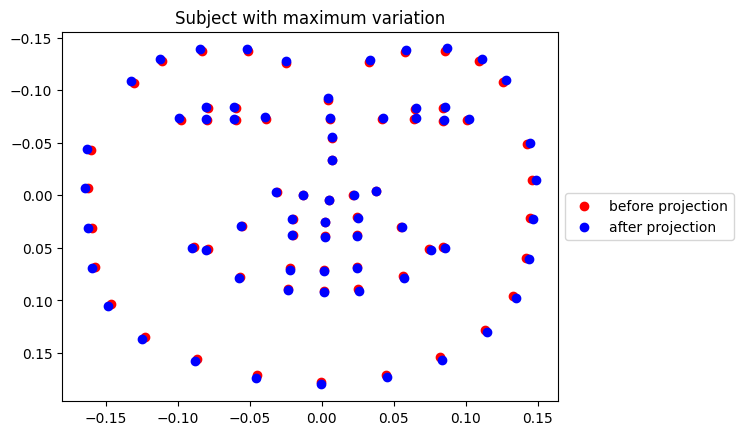

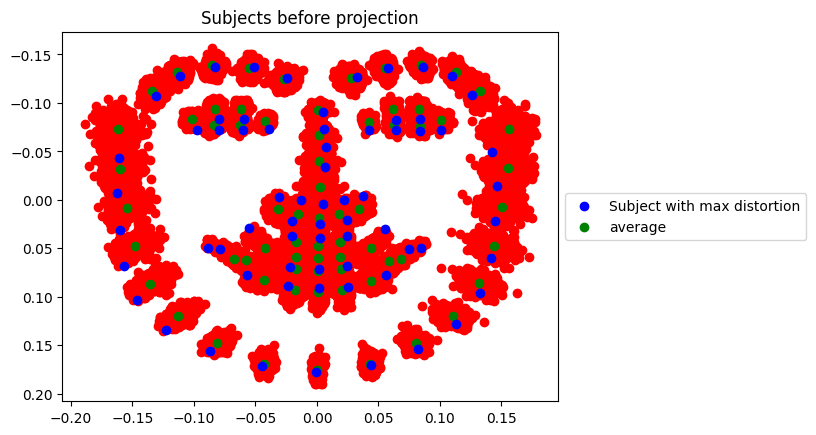

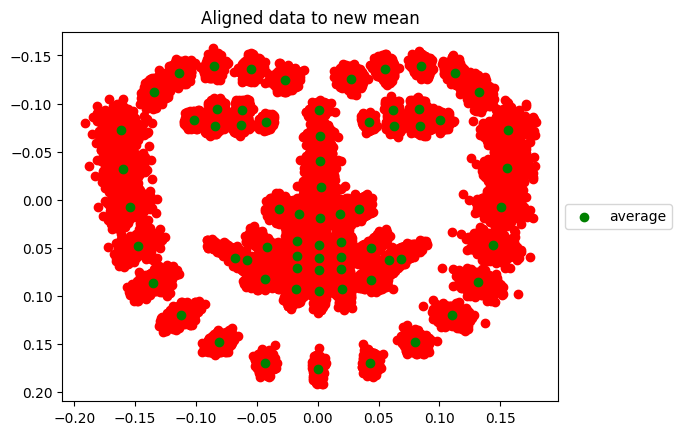

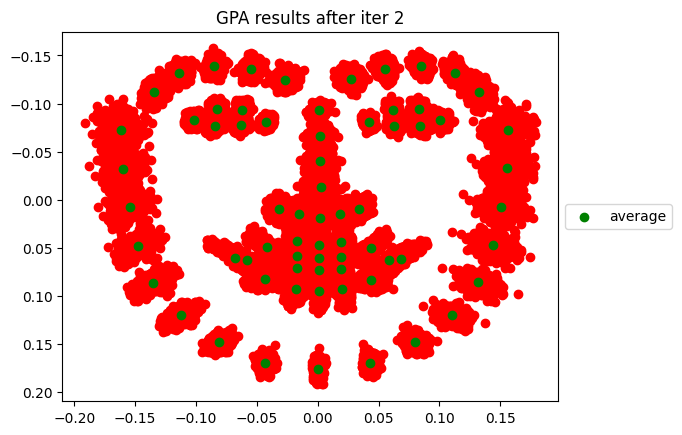

In [757]:
#  GPA (Generalized Procrustes Analysis)
X_sf, Xm1  = generalized_procrustes_analysis(Landmarks,tangent=1) #Sf for Shape free

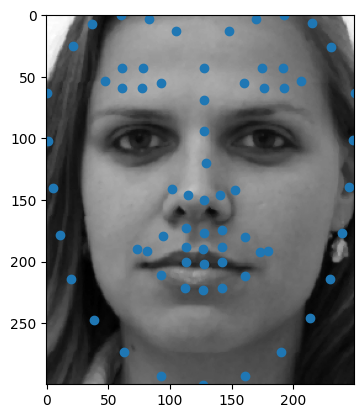

In [758]:
Is = Images[0]
Xm1_rescaled = rescale_to_original(Xm1.reshape(-1,2),H,W)
plt.scatter(Xm1_rescaled[:,0],Xm1_rescaled[:,1])
plt.imshow(Is, cmap='gray')
plt.show()

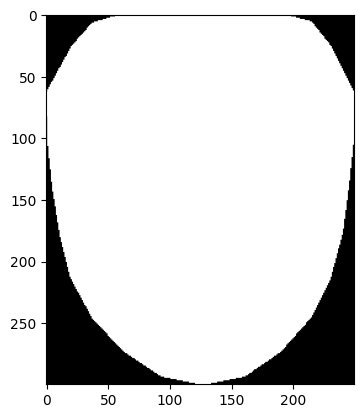

In [759]:
hull = ConvexHull(Xm1_rescaled)

hull_points = Xm1_rescaled[hull.vertices]

mask = np.zeros((H,W))

cv2.fillPoly(mask,[hull_points],1)

plt.imshow(mask,cmap='gray')

plt.show()

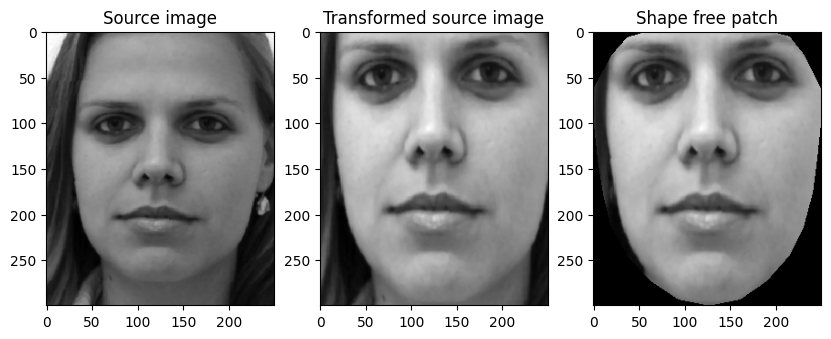

In [760]:
x_0 = Landmarks[0]
_, T = AffineRegistrationLandmarks(x_0.reshape(-1,2),Xm1_rescaled)

Ism = inverse_warping(Is,T,H,W)

fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(Is, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Ism, cmap='gray')
ax2.set_title('Transformed source image')
ax3.imshow(Ism*mask, cmap='gray')
ax3.set_title('Shape free patch')
plt.show()

In [761]:
#Converting all images to shape free images
SF_images = np.zeros((N,H,W))
for i in range(N):
    image = Images[i]
    landmark = Landmarks[i]
    _, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    shape_free_image = inverse_warping(image, T, H, W)
    shape_free_image = shape_free_image*mask
    SF_images[i] = shape_free_image

In [762]:
#Converting all images to shape free images
n_non_zero = len(np.nonzero(mask)[0])
SF_patches = np.zeros((N,n_non_zero))
for i in range(N):
    image = Images[i]
    landmark = Landmarks[i]
    _, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    shape_free_image = inverse_warping(image, T, H, W)
    shape_free_image = shape_free_image[mask>0]
    SF_patches[i] = shape_free_image

In [763]:
SF_landmarks = np.zeros((N,2*M))
for i in range(N):
    landmark = Landmarks[i]
    sf_landmark, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    SF_landmarks[i] = sf_landmark.reshape(-1)

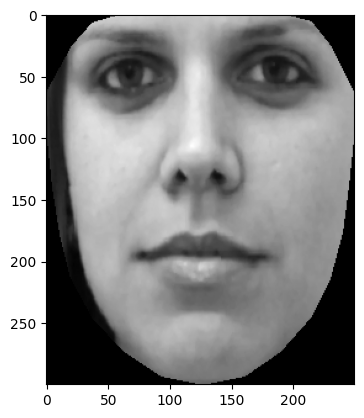

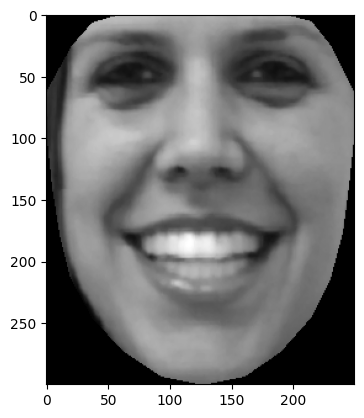

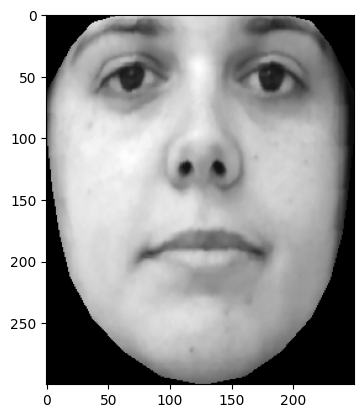

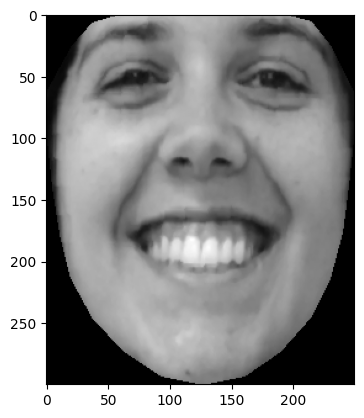

In [764]:
for i in range(4):
    plt.imshow(SF_images[i],cmap='gray')
    plt.show()

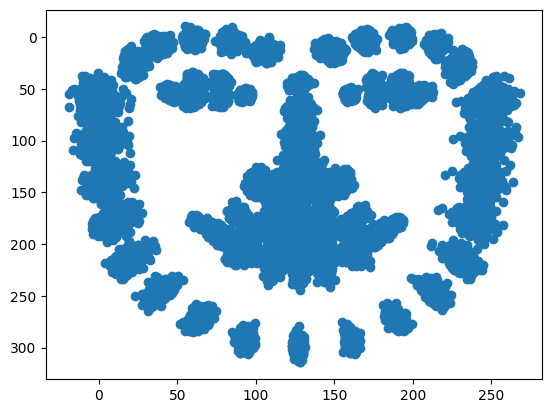

In [765]:
plt.scatter(SF_landmarks[:,::2].reshape(-1),SF_landmarks[:,1::2].reshape(-1))
plt.gca().invert_yaxis()
plt.show()

In [766]:
shape_size = SF_landmarks.shape[1]
texture_size = SF_patches.shape[1]
print(shape_size,texture_size)

136 61966


In [767]:
#1) Create Shape Model

pca_shape = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y_shape=pca_shape.fit_transform(SF_landmarks)
U_shape=pca_shape.components_.T # we want PC on columns
D_shape = (pca_shape.singular_values_)**2/(N-1) # computation of the eigenvalues
var_explained_shape = pca_shape.explained_variance_ratio_*100 # variance explained


print(Y_shape.shape)
print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained_shape[0], var_explained_shape[1], var_explained_shape[2]))

(400, 136)
The first three modes explain 32.229409, 30.108555 and 11.688427 of the total variability respectively


Pour avoir 95% de variance pour le modèle de forme, il suffit de garder les 12 premiers coefficients


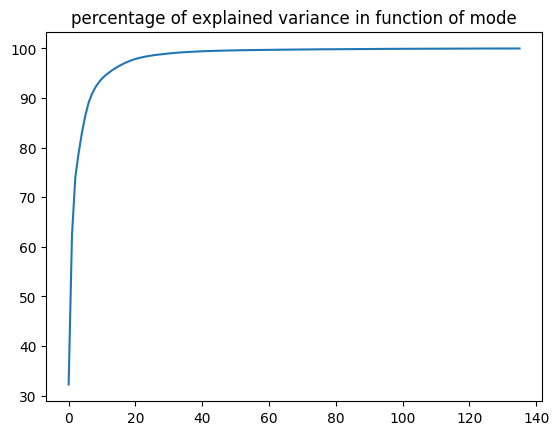

In [768]:
c = np.cumsum(var_explained_shape)
print(f"Pour avoir 95% de variance pour le modèle de forme, il suffit de garder les {np.where(c>=95)[0][0]} premiers coefficients")
plt.plot(c)
plt.title("percentage of explained variance in function of mode")
plt.show()

In [769]:
def show_variations(mean, D, U, show_shape=1):
    # Compute first mode
    first_mode_m= mean.reshape(-1) - 3*np.sqrt(D[0])*U[:,0]
    first_mode_p= mean.reshape(-1) + 3*np.sqrt(D[0])*U[:,0]
    
    # Compute second mode
    second_mode_m= mean.reshape(-1) - 3*np.sqrt(D[1])*U[:,1]
    second_mode_p= mean.reshape(-1) + 3*np.sqrt(D[1])*U[:,1]
    # Compute third mode
    third_mode_m= mean.reshape(-1) - 3*np.sqrt(D[2])*U[:,2]
    third_mode_p= mean.reshape(-1) + 3*np.sqrt(D[2])*U[:,2]
    
    
    if show_shape==1:
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r')
        plt.xlabel('- 3 std')
        plt.gca().invert_yaxis()
        plt.subplot(1, 3, 2)
        plt.scatter(Xm1_rescaled.reshape(-1)[::2], Xm1_rescaled.reshape(-1)[1::2], c='g')
        plt.xlabel('average')
        plt.title('First mode of deformation')
        plt.gca().invert_yaxis()
        plt.subplot(1, 3, 3)
        plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
        plt.xlabel('+ 3 std')
        plt.gca().invert_yaxis()
    
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r')
        plt.xlabel('- 3 std')
        plt.gca().invert_yaxis()
        plt.subplot(1, 3, 2)
        plt.scatter(Xm1_rescaled.reshape(-1)[::2], Xm1_rescaled.reshape(-1)[1::2], c='g')
        plt.xlabel('average')
        plt.title('Second mode of deformation')
        plt.gca().invert_yaxis()
        plt.subplot(1, 3, 3)
        plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
        plt.xlabel('+ 3 std')
        plt.gca().invert_yaxis()
    
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r')
        plt.xlabel('- 3 std')
        plt.gca().invert_yaxis()
        plt.subplot(1, 3, 2)
        plt.scatter(Xm1_rescaled.reshape(-1)[::2], Xm1_rescaled.reshape(-1)[1::2], c='g')
        plt.xlabel('average')
        plt.title('Third mode of deformation')
        plt.gca().invert_yaxis()
        plt.subplot(1, 3, 3)
        plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
        plt.xlabel('+ 3 std')
        plt.gca().invert_yaxis()
    # else:
    #     image_m_1 = np.zeros((H,W))
    #     image_m_1[mask>0] = texture_m
    #     image_p = np.zeros((H,W))
    #     image_p[mask>0] = texture_p
    #     plt.subplot(3,3,1)
    #     plt.imshow(image_p,cmap='gray')
    #     plt.subplot(3,3,2)
    #     plt.imshow(mean,cmap='gray')
    #     plt.subplot(3,3,3)
    #     plt.imshow(image_m,cmap='gray')
    #     plt.show()
            

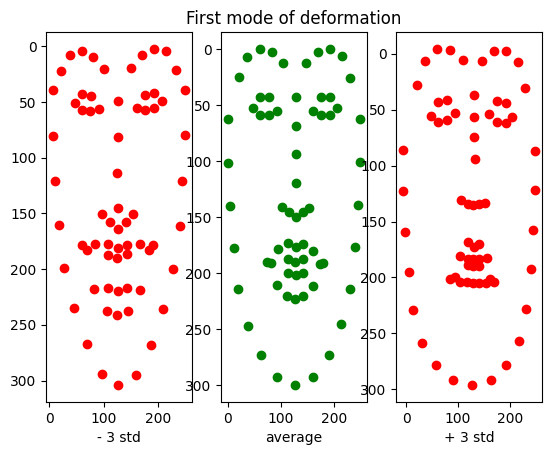

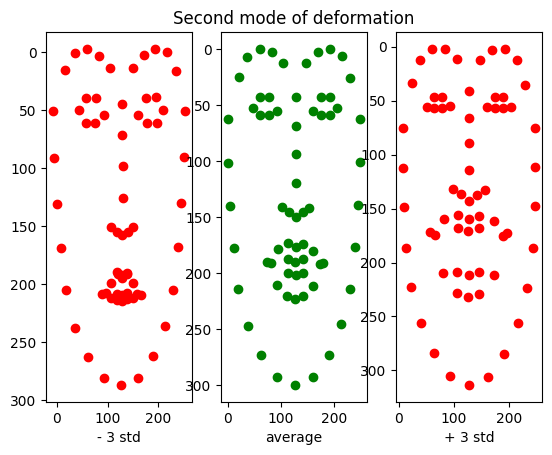

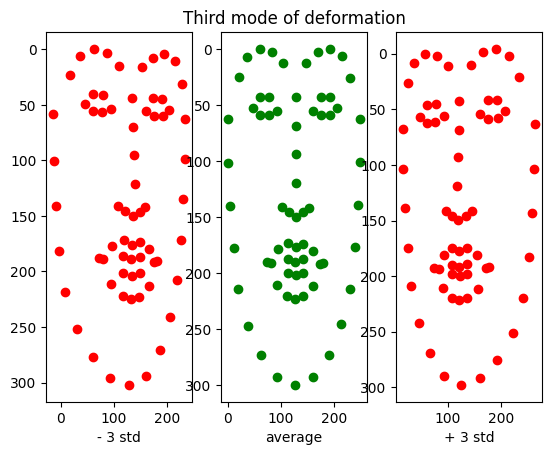

In [770]:
show_variations(Xm1_rescaled.reshape(-1),D_shape,U_shape)

In [771]:
#2) Create Texture Model

pca_texture = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y_texture=pca_texture.fit_transform(SF_patches)
U_texture=pca_texture.components_.T # we want PC on columns
D_texture = (pca_texture.singular_values_)**2/(N-1) # computation of the eigenvalues
var_explained_texture = pca_texture.explained_variance_ratio_*100 # variance explained


print(U_texture.shape)
print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained_texture[0], var_explained_texture[1], var_explained_texture[2]))

(61966, 400)
The first three modes explain 34.593665, 11.579340 and 7.289193 of the total variability respectively


Pour avoir 95% de variance pour le modèle de forme, il suffit de garder les 101 premiers coefficients


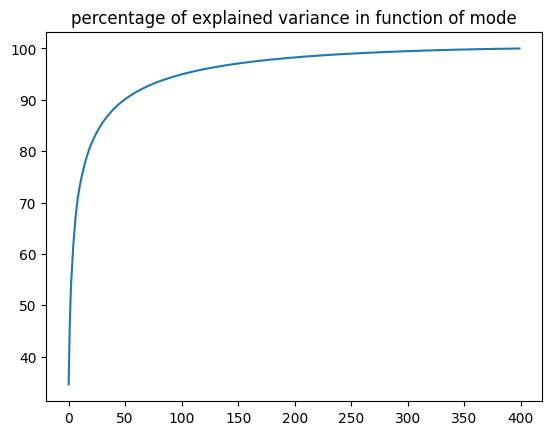

In [772]:
c = np.cumsum(var_explained_texture)
print(f"Pour avoir 95% de variance pour le modèle de forme, il suffit de garder les {np.where(c>=95)[0][0]} premiers coefficients")
plt.plot(c)
plt.title("percentage of explained variance in function of mode")
plt.show()

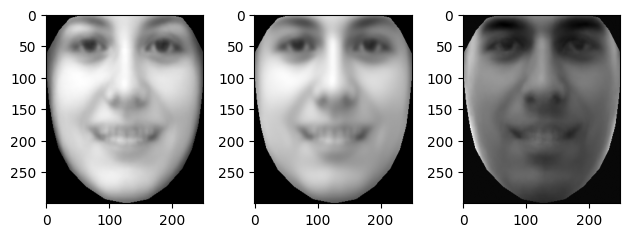

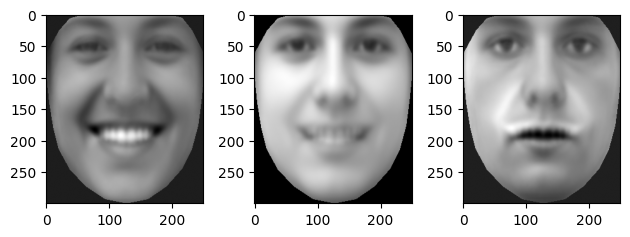

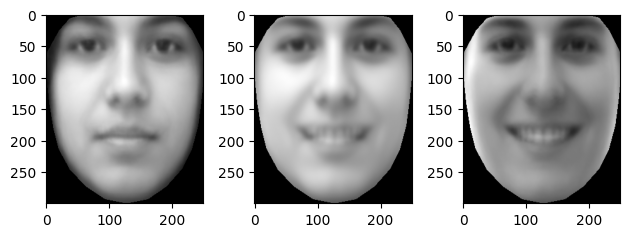

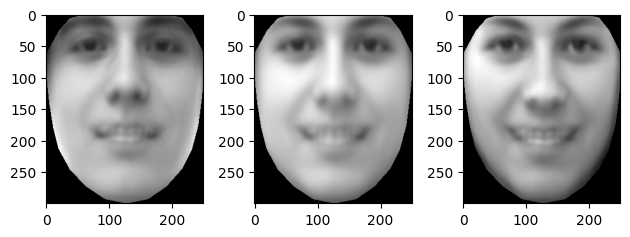

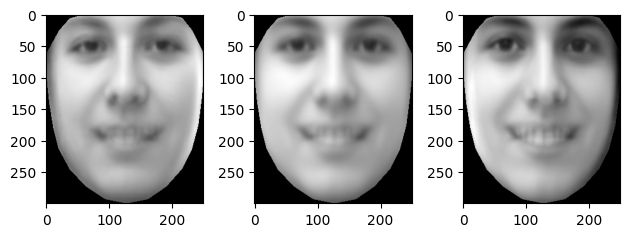

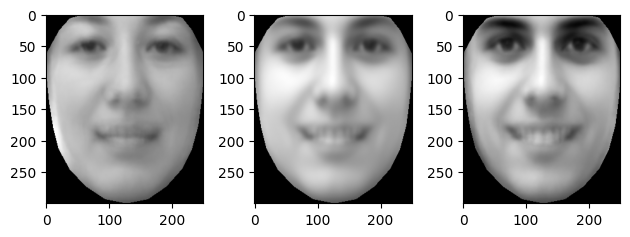

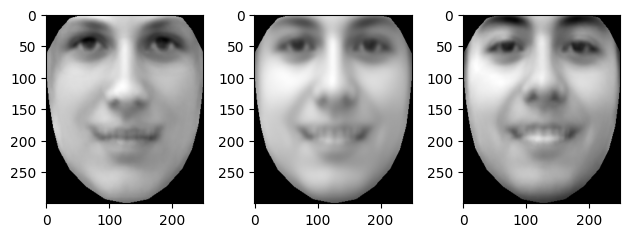

In [773]:
G_mean = np.mean(SF_patches,axis=0)
for i in range(7):
    first_mode_m= G_mean.reshape(-1) - 3*np.sqrt(D_texture[i])*U_texture[:,i]
    first_mode_p= G_mean.reshape(-1) + 3*np.sqrt(D_texture[i])*U_texture[:,i]
    
    image_m = np.zeros((H,W))
    image_m[mask>0] = first_mode_m
    image_p = np.zeros((H,W))
    image_p[mask>0] = first_mode_p
    image_mean = np.zeros((H,W))
    image_mean[mask>0] = G_mean
    
    plt.subplot(1,3,1)
    plt.imshow(image_p,cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(image_mean,cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(image_m,cmap='gray')
    plt.tight_layout()
    plt.show()

In [774]:
#Create Combined Model
n_modes_shape = 30
n_modes_texture = 300
variance_shape_reduced = pca_shape.explained_variance_[:n_modes_shape]
variance_texture_reduced = pca_texture.explained_variance_[:n_modes_texture]

weights_shape = 1.0 / np.sqrt(variance_shape_reduced + 1e-8)
weights_texture = 1.0 / np.sqrt(variance_texture_reduced + 1e-8)

Ws = np.diag(weights_shape / weights_texture.mean())
print(Ws.shape)
print(Y_shape[:,:n_modes_shape].shape)

weighted_shape_params = Y_shape[:,:n_modes_shape] @ Ws

combined_params = np.hstack([weighted_shape_params, Y_texture[:,:n_modes_texture]])
print(combined_params.shape) 

(30, 30)
(400, 30)
(400, 330)


In [775]:
#PCA on combined parameters
pca_combined = PCA(random_state=1)
appearance_params = pca_combined.fit_transform(combined_params)
U_combined = pca_combined.components_.T # we want PC on columns
D_combined = (pca_combined.singular_values_)**2/(N-1) # computation of the eigenvalues
var_explained_combined = pca_combined.explained_variance_ratio_*100 # variance explained

print(U_combined.shape)
print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained_combined[0], var_explained_combined[1], var_explained_combined[2]))

(330, 330)
The first three modes explain 34.480133, 11.563187 and 7.280524 of the total variability respectively


Pour avoir 95% de variance pour le modèle de forme, il suffit de garder les 96 premiers coefficients


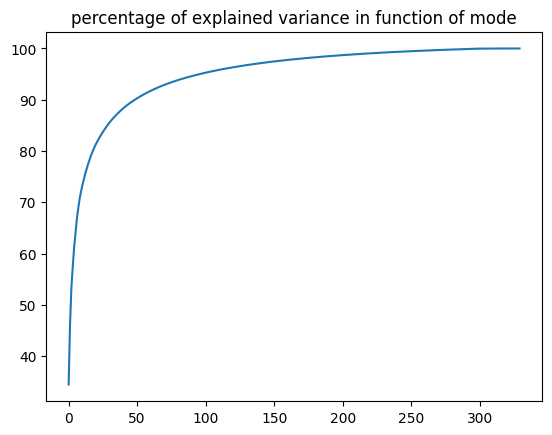

In [776]:
c = np.cumsum(var_explained_combined)
print(f"Pour avoir 95% de variance pour le modèle de forme, il suffit de garder les {np.where(c>=95)[0][0]} premiers coefficients")
plt.plot(c)
plt.title("percentage of explained variance in function of mode")
plt.show()

In [777]:
n_modes_combined = 200
i=0
first_mode_m =  -3*np.sqrt(D_combined[i])*U_combined[:,i]
first_mode_p =  3*np.sqrt(D_combined[i])*U_combined[:,i]

reconstructed_weighted_shape_m = first_mode_m[:n_modes_shape]
reconstructed_texture_m = first_mode_m[n_modes_shape:]

reconstructed_weighted_shape_p = first_mode_p[:n_modes_shape]
reconstructed_texture_p = first_mode_p[n_modes_shape:]

reconstructed_shape_m = reconstructed_weighted_shape_m @ np.linalg.inv(Ws)
reconstructed_shape_p = reconstructed_weighted_shape_p @ np.linalg.inv(Ws)
print(reconstructed_weighted_shape_p.shape)
print(reconstructed_texture_p.shape)

final_shape_m = Xm1_rescaled.reshape(-1) + U_shape[:,:n_modes_shape] @ reconstructed_shape_m
final_shape_p = Xm1_rescaled.reshape(-1) + U_shape[:,:n_modes_shape] @ reconstructed_shape_p

final_texture_m = G_mean.reshape(-1) + U_texture[:,:n_modes_texture] @ reconstructed_texture_m
final_texture_p =  G_mean.reshape(-1) + U_texture[:,:n_modes_texture] @ reconstructed_texture_p

(30,)
(300,)


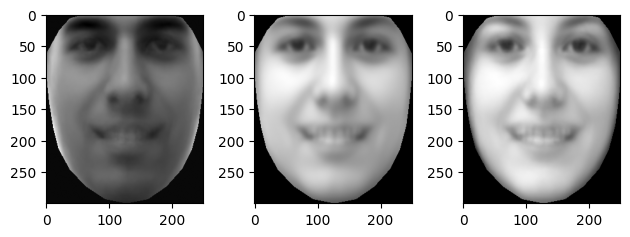

In [778]:
image_m = np.zeros((H,W))
image_m[mask>0] = final_texture_m
image_p = np.zeros((H,W))
image_p[mask>0] = final_texture_p
image_mean = np.zeros((H,W))
image_mean[mask>0] = G_mean

plt.subplot(1,3,1)
plt.imshow(image_m,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_mean,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_p,cmap='gray')
plt.tight_layout()
plt.show()

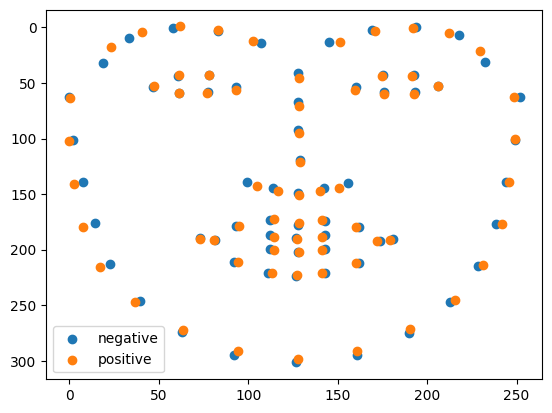

In [779]:
plt.scatter(final_shape_m[::2],final_shape_m[1::2],label="negative")
plt.scatter(final_shape_p[::2],final_shape_p[1::2],label="positive")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [780]:
#Converting all images to shape free images
SF_images_no_mask = np.zeros((N,H,W))
for i in range(N):
    image = Images[i]
    landmark = Landmarks[i]
    _, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    shape_free_image = inverse_warping(image, T, H, W)
    SF_images_no_mask[i] = shape_free_image
print(SF_images.shape)

(400, 300, 250)


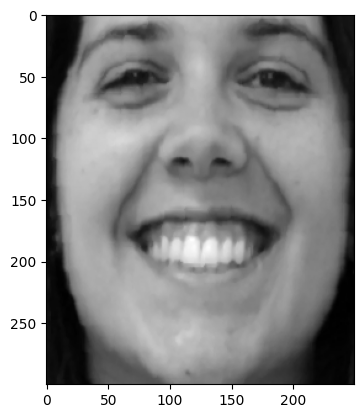

In [781]:
img = SF_images_no_mask[3]
img_t = inverse_warping(img, np.eye(3), H, W)
plt.imshow(img,cmap='gray')
plt.show()

(330,)
(330,)


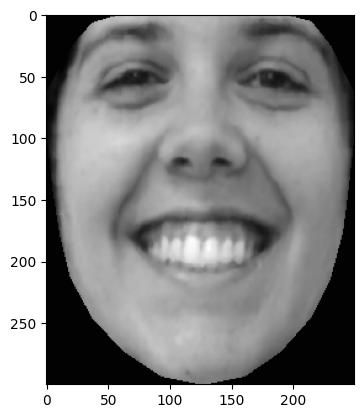

In [782]:
c_all = np.zeros(n_modes_shape+n_modes_texture)
c_all[:n_modes_combined] = combined_params[3,:n_modes_combined]
c_combined_opt = pca_combined.transform(c_all.reshape(1, -1))[0]
combined_params_opt = pca_combined.inverse_transform(c_combined_opt.reshape(1, -1))
weighted_shape_opt = combined_params_opt[:, :n_modes_shape]
texture_params_opt = combined_params_opt[:, n_modes_shape:]
shape_opt = Xm1_rescaled.reshape(-1,1) +  pca_shape.components_.T[:,:n_modes_shape] @ (weighted_shape_opt @ np.linalg.inv(Ws)).T
shape_opt = shape_opt.reshape(-1)
g_m_opt = G_mean.reshape(-1,1) + pca_texture.components_.T[:,:n_modes_texture] @ texture_params_opt.T
g_m_opt = g_m_opt.reshape(-1)
print(c_combined_opt.shape)
image = np.zeros((H,W))
image[mask>0] = g_m_opt
print(c_all.shape)
plt.imshow(image,cmap='gray')
plt.show()

In [783]:
print(c_all.shape)

(330,)


In [784]:
a = np.array([1,2,5,2,2])
print(a[-4:])
print(np.pi/20)

[2 5 2 2]
0.15707963267948966


In [785]:
print(n_modes_shape+n_modes_texture)

330


In [786]:
combined_params_ = pca_combined.inverse_transform(c.reshape(1, -1))
weighted_shape = combined_params_[:, :n_modes_shape]
texture_params = combined_params_[:, n_modes_shape:]

shape = Xm1_rescaled.reshape(-1,1) + pca_shape.components_.T[:,:n_modes_shape] @ (weighted_shape @ np.linalg.inv(Ws)).T
g_m = G_mean.reshape(-1,1) + pca_texture.components_.T[:,:n_modes_texture] @ texture_params.T
g_m = g_m.reshape(-1)

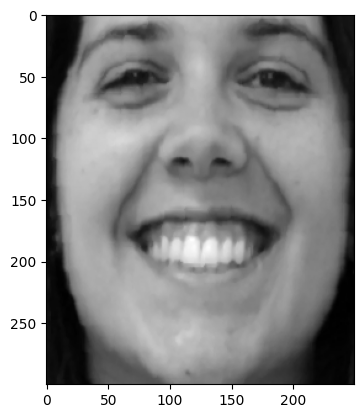

In [787]:
plt.imshow(img,cmap='gray')

# Learning weights from Training images

In [888]:
def build_transform_matrix(t):
    """Crée une matrice de transformation 3x3 à partir de [tx, ty, scale, theta]."""
    tx, ty, scale, theta = t
    T = np.array([
        [scale * np.cos(theta), -scale * np.sin(theta), tx],
        [scale * np.sin(theta), scale * np.cos(theta), ty],
        [0, 0, 1]
    ])
    return T

In [830]:
from tqdm import tqdm
def compute_R_matrix(original_images, SF_landmarks, mask, mean_shape, mean_texture,
                     pca_shape, pca_texture, pca_combined, Ws, inverse_warping,
                     combined_params, H, W,  # Variables ajoutées
                     n_modes_shape=n_modes_shape, n_modes_texture=n_modes_texture, n_modes_combined=n_modes_combined,lambda_reg=1e-6):
    """
    Calcule la matrice R via différentiation numérique.
    
    Paramètres :
        original_images : Liste des images originales (non warped).
        SF_landmarks : Landmarks alignés (pour reconstruire les paramètres optimaux).
        mask : Masque pour extraire la texture.
        mean_shape, mean_texture : Moyennes des modèles.
        pca_shape, pca_texture, pca_combined : Modèles PCA.
        Ws : Matrice de poids pour la forme.
        inverse_warping : Fonction de warping.
        lambda_reg : Terme de régularisation.
    """
    N = len(original_images)
    n_pixels = int(mask.sum())  # Taille du vecteur de texture
    n_modes_combined = n_modes_combined
    n_transform_params = 4  # [tx, ty, scale, theta]
    n_total_params = n_modes_combined + n_transform_params
    
    # Initialisation de la Jacobienne et des sigmas
    J = np.zeros((n_pixels, n_total_params))
    sigma = np.zeros(n_total_params)  # À adapter selon les données
    
    # Variance des paramètres (ex: issues des PCA)
    sigma[:n_modes_combined] = np.sqrt(pca_combined.explained_variance_[:n_modes_combined])
    sigma[-4:] = np.array([5,5,0.3,np.pi/20])
    
    for img_idx, img in tqdm(enumerate(original_images), total=N, desc="Calcul de R"):
        # Paramètres optimaux pour l'image i
        c_combined_opt = pca_combined.transform(combined_params[img_idx].reshape(1, -1))[0]
        t_opt = np.array([0.0, 0.0, 1.0, 0.0])  # Identity (tx, ty, scale, theta)
        
        # Texture optimale (g_m)
        combined_params_opt = pca_combined.inverse_transform(c_combined_opt.reshape(1, -1))
        weighted_shape_opt = combined_params_opt[:, :n_modes_shape]
        texture_params_opt = combined_params_opt[:, n_modes_shape:]
        shape_opt = mean_shape.reshape(-1,1) +  pca_shape.components_.T[:,:n_modes_shape] @ (weighted_shape_opt @ np.linalg.inv(Ws)).T
        g_m_opt = mean_texture.reshape(-1,1) + pca_texture.components_.T[:,:n_modes_texture] @ texture_params_opt.T
        shape_opt = shape_opt.reshape(-1) 
        g_m_opt = g_m_opt.reshape(-1) 
        
        # Résidu initial (r_opt)
        g_s_opt = inverse_warping(img, np.eye(3), H, W)
        r_opt = g_s_opt[mask>0] - g_m_opt
        
        # Perturbation de chaque paramètre
        for param_j in range(n_total_params):
            delta_perturbations = np.linspace(-0.01 * sigma[param_j], 0.01 * sigma[param_j], 2)
            delta_perturbations = delta_perturbations[delta_perturbations != 0]
            total_weight = 0.0
            for delta in delta_perturbations:
            
                if param_j < n_modes_combined:
                    # Perturbation de c_combined
                    c_combined_perturbed = c_combined_opt.copy()
                    c_combined_perturbed[param_j] += delta
                    
                    # Reconstruction de la forme et texture
                    combined_params_perturbed = pca_combined.inverse_transform(c_combined_perturbed.reshape(1, -1))
                    weighted_shape_perturbed = combined_params_perturbed[:, :n_modes_shape]
                    texture_params_perturbed = combined_params_perturbed[:, n_modes_shape:]
                    shape_perturbed = mean_shape.reshape(-1,1) + pca_shape.components_.T[:,:n_modes_shape] @ (weighted_shape_perturbed @ np.linalg.inv(Ws)).T 
                    g_m_perturbed = mean_texture.reshape(-1,1) + pca_texture.components_.T[:,:n_modes_texture] @ texture_params_perturbed.T 
                    shape_perturbed = shape_perturbed.reshape(-1)
                    g_m_perturbed = g_m_perturbed.reshape(-1)
                    
                    # Application de la transformation optimale (t_opt)
                    T_opt = build_transform_matrix(t_opt)  # À implémenter
                    g_s_perturbed = inverse_warping(img, T_opt, mask.shape[0], mask.shape[1])
                    
                else:
                    # Perturbation de t (tx, ty, scale, theta)
                    t_perturbed = t_opt.copy()
                    t_perturbed[param_j - n_modes_combined] += delta
                    T_perturbed = build_transform_matrix(t_perturbed)  # À implémenter
                    
                    # Reconstruction de la forme avec t_perturbed
                    combined_params_opt = pca_combined.inverse_transform(c_combined_opt.reshape(1, -1))
                    weighted_shape_opt = combined_params_opt[:, :n_modes_shape]
                    shape_opt = mean_shape.reshape(-1,1) + (weighted_shape_opt @ np.linalg.inv(Ws)) @ pca_shape.components_[:n_modes_shape]
                    g_s_perturbed = inverse_warping(img, T_perturbed, mask.shape[0], mask.shape[1])
                    g_m_perturbed = g_m_opt  # La texture modèle reste inchangée
                
                # Calcul du résidu perturbé
                r_perturbed = g_s_perturbed[mask>0] - g_m_perturbed
                
                # Dérivée et pondération
                dr = r_perturbed - r_opt
                derivative = dr / delta
                weight = np.exp(-delta**2 / (2 * sigma[param_j]**2)) / abs(delta)
                
                J[:, param_j] += weight * derivative
                total_weight += weight
                
            if total_weight>0:    
                J[:, param_j] = J[:, param_j] / total_weight

    
    # Moyenne sur toutes les images et calcul de R
    J /= N
    J_T = J.T
    R = np.linalg.inv(J_T @ J + lambda_reg * np.eye(n_total_params)) @ J_T
    
    return J, R

In [836]:
J, R = compute_R_matrix(SF_images_no_mask[:5], SF_landmarks, mask, Xm1_rescaled, G_mean,
                     pca_shape, pca_texture, pca_combined, Ws, inverse_warping, combined_params, H, W,
                     n_modes_shape, n_modes_texture,n_modes_combined, lambda_reg=0)

Calcul de R: 100%|████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


In [829]:
print(R)

[[-2.63711188e-24 -2.69079947e-24 -2.73972260e-24 ... -5.95463154e-25
  -5.27806720e-25 -3.65231658e-25]
 [-1.12448558e-19 -1.10879461e-19 -1.09305783e-19 ... -2.74943988e-19
  -2.84631446e-19 -2.93607542e-19]
 [ 1.64933057e-17  1.69853873e-17  1.72292203e-17 ...  2.53409975e-17
   2.64852965e-17  2.75219662e-17]
 ...
 [-5.76611314e-03 -5.52422580e-03 -5.28812926e-03 ... -2.72276415e-04
  -4.19796664e-04 -4.43657841e-04]
 [ 8.19786750e-06  8.30182370e-06  8.27138883e-06 ...  1.35024985e-05
   1.43385678e-05  1.51960889e-05]
 [ 3.01180885e-05  2.83822423e-05  2.66354077e-05 ...  4.38675831e-06
   5.61118019e-06  5.72380723e-06]]


(300, 250)


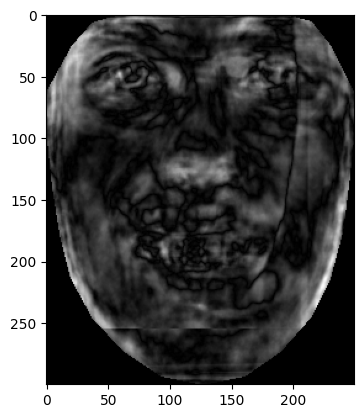

In [812]:
image = np.zeros((H,W))
image[mask>0] = R[3,:]
print(image.shape)
plt.imshow(np.abs(image-np.mean(image)),cmap='gray')
plt.show()

# Iterative pose estimation

In [954]:
img = SF_images_no_mask[10]
T = build_transform_matrix((0,0,1,0))
print(T)

[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


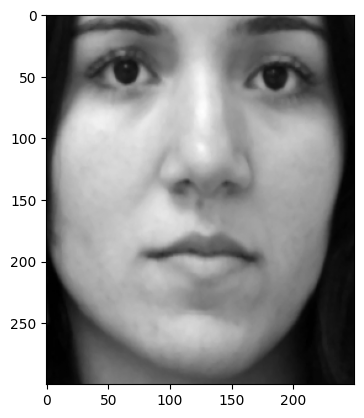

In [955]:
img_warped = inverse_warping(img,T,H,W)
plt.imshow(img_warped,cmap='gray')
plt.show()

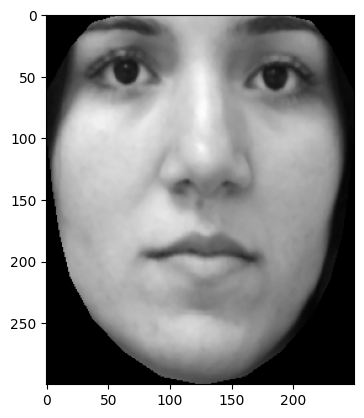

In [797]:
img_masked = img_warped*mask
plt.imshow(img_masked,cmap='gray')
plt.show()

In [747]:
# c_all = np.zeros(n_modes_shape+n_modes_texture)
# c = np.zeros(n_modes_combined)
# c_all[:n_modes_combined] = c
# combined_params = pca_combined.inverse_transform(c_all.reshape(1, -1))

# weighted_shape = combined_params[:, :n_modes_shape]
# texture_params = combined_params[:, n_modes_shape:]

# shape = Xm1_rescaled.reshape(-1,1) + pca_shape.components_.T[:,:n_modes_shape] @ (weighted_shape @ np.linalg.inv(Ws)).T 
# g_m = G_mean.reshape(-1,1) + pca_texture.components_.T[:,:n_modes_texture] @ texture_params.T 

# shape = shape.reshape(-1)
# g_m = g_m.reshape(-1)

# t = np.array([0,0,1,0])
# g_s = inverse_warping(img_warped,T,H,W)[mask>0]

# p = np.concatenate((c,t))

# r = g_s-g_m
# E = np.sum(r**2)
# print(E)

43428785.281072766


In [748]:
delta_p = -R @ r
p = p + delta_p
print(delta_p)
print(delta_p.shape)

[ 2.66686384e+00 -4.05723328e+00  3.96128532e+01  3.07785180e+00
 -8.32811958e+01  2.90850833e+01  3.21151064e+01 -1.00601405e+02
  1.94579256e+01 -1.10287161e+02 -1.76406354e+02  1.59300494e+02
 -6.63045944e+01 -1.37139195e+02  2.46271176e+02 -2.69904581e+02
 -2.50961143e+02 -2.69113592e+02 -4.88183872e+00 -1.74247069e+02
  1.36586367e+02  1.13946399e+02  1.33397528e+02  1.32935689e+02
 -1.03005938e+02  2.79364693e+01 -2.82464373e+02 -2.85563272e+02
  8.90663097e+01 -2.66984596e+02 -5.62962157e+02 -3.77185675e+02
 -3.48036755e+02  5.45979568e+01 -5.33287873e+02  1.58461118e+02
 -5.88519810e+01 -5.56088136e+01  7.72072796e+02  5.46730575e+02
 -5.33764992e+02 -4.86842195e+02  3.81955518e+02  3.03273376e+02
  4.48617655e+02 -7.55003726e+02 -8.98267088e+02 -1.09696939e+02
 -1.24706249e+02 -2.48890786e+02 -1.50164591e+01 -4.50374476e+01
  3.62174128e+02 -1.66500190e+02  4.86630890e+02 -6.19386670e+02
  1.34541260e+01 -2.13255861e+02 -1.65645138e+02  2.39821264e+02
  1.28651455e+02  4.06431

In [749]:
print(p.shape)

(204,)


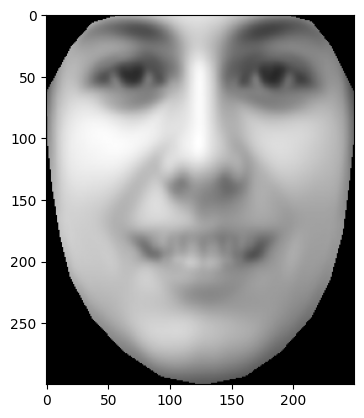

In [750]:
image = np.zeros((H,W))
image[mask>0] = g_m
plt.imshow(image,cmap='gray')
plt.show()

In [948]:
def aam_iterative_fitting(img_warped, mask, Xm1_rescaled, G_mean, 
                         pca_shape, pca_texture, pca_combined, Ws,
                         inverse_warping, R, 
                         n_modes_shape, n_modes_texture, n_modes_combined,
                         max_iter=1000, tolerance=10000):
    """
    Algorithme d'ajustement itératif AAM avec recherche linéaire
    ne faisant que réduire l'erreur.
    
    Paramètres:
        img_warped: Image cible à ajuster
        mask: Masque de la région d'intérêt
        Xm1_rescaled: Vecteur de forme moyen(é)
        G_mean: Vecteur de texture moyen(é)
        R: Matrice de prédiction (inverse Hessienne approximée)
        max_iter: Nombre maximum d'itérations
        tolerance: Seuil de convergence
        
    Retourne:
        p: Paramètres optimisés [c|t]
        E: Historique des erreurs
        shape: Forme finale
        g_m: Texture modèle finale
    """

    # Initialisation
    c_all = np.zeros(n_modes_shape + n_modes_texture)
    c = np.zeros(n_modes_combined)
    c_all[:n_modes_combined] = c
    
    # Paramètres de transformation (ex : tx, ty, scale, theta)
    t = np.array([0.0, 0.0, 1.0, 0.0])
    H, W = mask.shape
    E = []
    p = np.concatenate((c, t))
    
    # Séquence de pas pour la recherche linéaire
    k_values = np.array([2**k for k in range(-30, 0)])  # Ajustez selon vos besoins
    
    for i in tqdm(range(max_iter), desc="AAM Fitting"):
        # -- Etape 1 & 2 : Calcul de la forme et de la texture courantes
        # Re-déplie c_all pour récupérer la forme et la texture.
        # Ici on suppose que pca_combined transforme [shape_params|texture_params].
        combined_params = pca_combined.inverse_transform(c_all.reshape(1, -1))
        
        weighted_shape = combined_params[:, :n_modes_shape]
        texture_params  = combined_params[:, n_modes_shape:]
        
        # Calcul de la forme (shape)
        # shape = moyenne + composantes_shapes * weighted_shape * inverse Ws
        shape = (Xm1_rescaled.reshape(-1,1) 
                 + pca_shape.components_.T[:, :n_modes_shape] 
                   @ (weighted_shape @ np.linalg.inv(Ws)).T )
        shape = shape.ravel()
        
        # Calcul de la texture (g_m)
        g_m = (G_mean.reshape(-1,1) 
               + pca_texture.components_.T[:, :n_modes_texture] 
                 @ texture_params.T )
        g_m = g_m.ravel()
        
        # Warping inverse pour récupérer la texture de l'image courante
        T_mat = build_transform_matrix(t)
        g_s = inverse_warping(img_warped, T_mat, H, W)[mask > 0]
        
        # Calcul de l'erreur de reconstruction
        r = g_s - g_m
        current_error = np.sum(r**2)
        E.append(current_error)
        
        # -- Critère d'arrêt 1: si l'erreur est en dessous du seuil
        if current_error < tolerance:
            print(f"Convergence atteinte à l'itération {i} avec une erreur = {current_error:.2f}")
            break
        
        # -- Etape 3 : calcul de la direction de descente (delta_p)
        # delta_p = -(R @ r), si R est l'approx. d'inverse Hessienne
        delta_p = - R @ r
        
        # -- Recherche linéaire sur k
        best_error = current_error
        best_k = 0.0
        
        for k in k_values:
            # On teste p_try = p + k * delta_p
            p_try = p + k * delta_p
            c_try = p_try[:n_modes_combined]
            t_try = p_try[n_modes_combined:]
            
            # On crée un vecteur c_try_all pour l'inverse_transform
            c_try_all = np.zeros(n_modes_shape + n_modes_texture)
            c_try_all[:n_modes_combined] = c_try
            
            combined_try = pca_combined.inverse_transform(c_try_all.reshape(1, -1))
            
            # Récupération séparée des coeffs de forme et de texture
            shape_try_w  = combined_try[:, :n_modes_shape]
            texture_try_w = combined_try[:, n_modes_shape:]
            
            shape_try = (Xm1_rescaled.reshape(-1,1)
                         + pca_shape.components_.T[:, :n_modes_shape]
                           @ (shape_try_w @ np.linalg.inv(Ws)).T ).ravel()
            
            g_m_try = (G_mean.reshape(-1,1)
                       + pca_texture.components_.T[:, :n_modes_texture]
                         @ texture_try_w.T ).ravel()

            # Warping inverse pour l'essai
            T_try = build_transform_matrix(t_try)
            g_s_try = inverse_warping(img_warped, T_try, H, W)[mask > 0]
            
            error_try = np.sum((g_s_try - g_m_try)**2)
            
            # Mise à jour du best_error si on trouve mieux
            if error_try < best_error:
                best_error = error_try
                best_k = k
        
        # -- Après la recherche linéaire, on vérifie si on a trouvé un k qui diminue l'erreur
        if best_error < current_error:
            # On met à jour p avec le meilleur pas best_k
            p = p + best_k * delta_p
            c = p[:n_modes_combined]
            t = p[n_modes_combined:]
            
            # Mémoriser aussi pour la prochaine itération :
            c_all[:n_modes_combined] = c
            
        else:
            # Si aucune amélioration, on arrête l'itération
            print(f"Aucune amélioration à l'itération {i}. On arrête.")
            break
    
    # Recalcul final de shape et g_m pour renvoyer la dernière version cohérente
    combined_params = pca_combined.inverse_transform(c_all.reshape(1, -1))
    weighted_shape = combined_params[:, :n_modes_shape]
    texture_params = combined_params[:, n_modes_shape:]
    shape = (Xm1_rescaled.reshape(-1,1) 
             + pca_shape.components_.T[:, :n_modes_shape] 
               @ (weighted_shape @ np.linalg.inv(Ws)).T).ravel()
    g_m = (G_mean.reshape(-1,1) 
           + pca_texture.components_.T[:, :n_modes_texture] 
             @ texture_params.T).ravel()

    return p, E, shape, g_m

In [752]:
print(n_modes_shape+n_modes_texture)

330


In [957]:
p, E, shape, g_m = aam_iterative_fitting(img_warped, mask, Xm1_rescaled, G_mean, 
                         pca_shape, pca_texture, pca_combined, Ws,
                         inverse_warping, R, 
                         n_modes_shape, n_modes_texture, n_modes_combined,
                         max_iter=50, tolerance=10000)

AAM Fitting: 100%|██████████████████████████████| 50/50 [00:06<00:00,  7.85it/s]


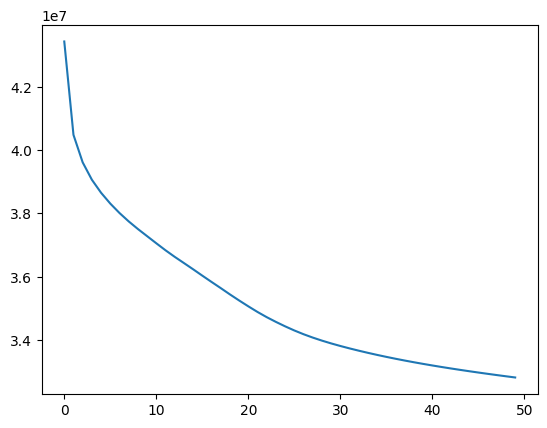

In [958]:
plt.plot(E)
plt.show()

In [587]:
print(p[-4:])

[0. 0. 1. 0.]


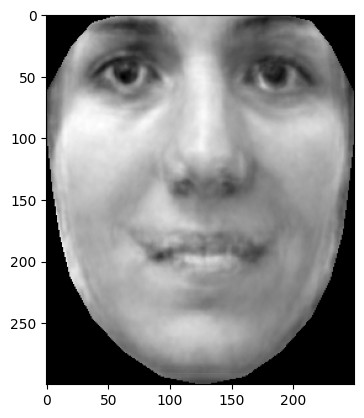

In [959]:
image = np.zeros((H,W))
image[mask>0] = g_m
plt.imshow(image,cmap='gray')
plt.show()

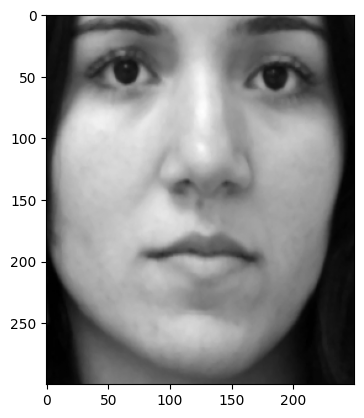

In [892]:
plt.imshow(img_warped,cmap='gray')